In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.dates as mdates
import datetime
import holidays
import folium


In [2]:
from plotly import __version__
import cufflinks as cf

In [3]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [4]:
%matplotlib inline

# Load data sets

In [5]:
# dataset 1
# https://www.dataquest.io/blog/pandas-big-data/
df = pd.read_csv("Sample_RH_dataset_clean_final.csv")

In [6]:
# dataset with predictions of 3 Sides
# df_plots.iloc[8179:]
df_plots = pd.read_csv("prediction_plots.csv")

df_plots["StartTime"] = pd.to_datetime(df_plots["StartTime"], 
                                       format="%d/%m/%Y %H:%M")

# set index
df_plots.set_index("StartTime", inplace=True)

In [7]:
df_plots.iloc[8179:8181]

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,...,HW_CEN,ARIMA_FNS,ARIMA_Ohare,ARIMA_CEN,Prophet_FNS,Prophet_Ohare,Prophet_CEN,LSTM_FNS,LSTM_Ohare,LSTM_CEN
StartTime,,,,,,,,,,,,,,,,,,,,,
2019-10-07 19:00:00,92,95,33,210,273,504,99,64,19,6,...,472.109913,96.464738,87.868742,511.865591,110.051664,86.474091,503.302692,NaN,NaN,NaN
2019-10-07 20:00:00,61,99,26,217,254,424,77,56,25,15,...,405.317574,94.951638,83.388702,501.900589,105.113916,89.178644,462.722474,58.148285,84.032455,408.773956


In [8]:
df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"])
df.set_index("Trip Start Timestamp", inplace=True, drop=False)
df.describe().astype(int)

,Unnamed: 0,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Pickup Census Tract,Dropoff Census Tract,Trip Total,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,1142290,1140087,1142244,1069403,1061340,819473,814967,1142288,1142290,1070343,1070343,1062322,1062322
mean,574926,1100,6,25,26,17031368985,17031381274,15,1,41,-87,41,-87
std,332086,785,6,20,20,336204,341256,12,0,0,0,0,0
min,0,61,0,1,1,17031010000,17031010000,2,1,41,-87,41,-87
25%,287091,548,1,8,8,17031081000,17031081000,7,1,41,-87,41,-87
50%,575036,885,3,24,24,17031242000,17031243000,12,1,41,-87,41,-87
75%,862531,1425,7,32,32,17031833000,17031833000,17,1,41,-87,41,-87
max,1149999,10603,170,77,77,17031980000,17031980000,199,15,42,-87,42,-87


In [9]:
# convert trip miles in trip kilometers and trip seconds to trip minutes
df["Trip kilometers"] = df["Trip Miles"] * 1.609344
df["Trip minutes"] = df["Trip Seconds"] / 60

# Vizzies

In [10]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [11]:
plt.style.use("seaborn")

# Outlier detection

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



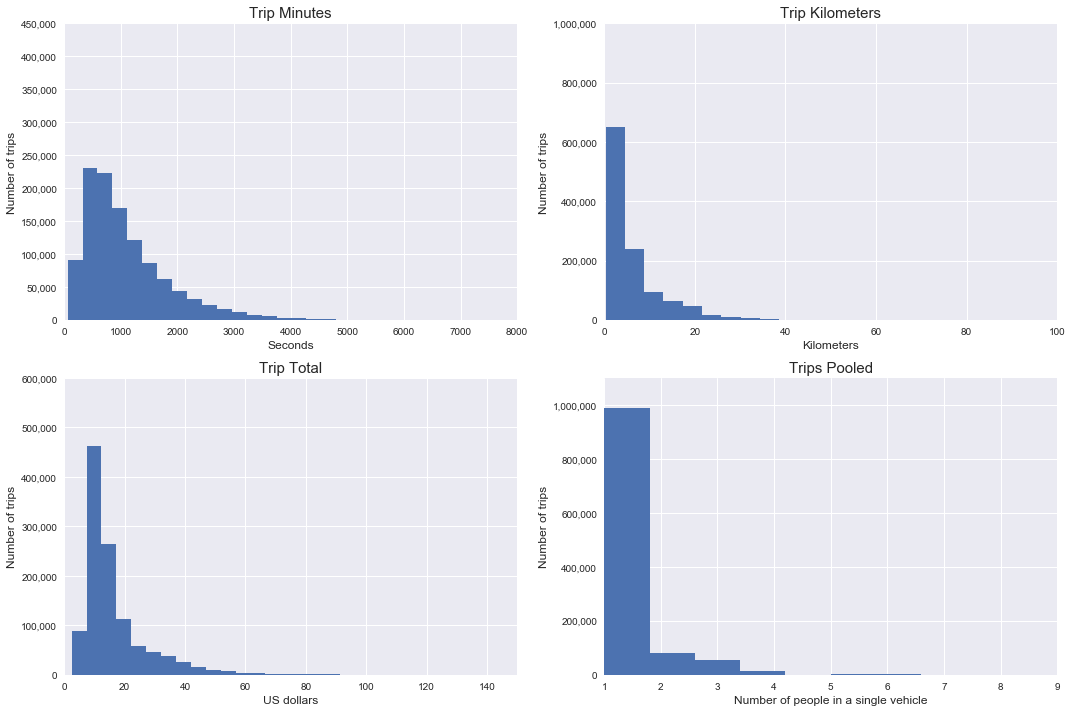

In [72]:
# trip duration, distance, total, pooled"
low_pool = df["Trips Pooled"] < 10

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax[0, 0].hist(df["Trip Seconds"], bins=40, label="Trips")
ax[0, 1].hist(df["Trip Miles"], bins=40, label="Trips")
ax[1, 0].hist(df["Trip Total"], bins=40, label="Trips")
ax[1, 1].hist(df[low_pool]["Trips Pooled"], label="Trips")

ax[0, 0].set_title("Trip Minutes", fontsize=15)
ax[0, 1].set_title("Trip Kilometers", fontsize=15)
ax[1, 0].set_title("Trip Total", fontsize=15)
ax[1, 1].set_title("Trips Pooled", fontsize=15)

ax[0, 0].set_xlabel("Seconds", fontsize=12)
ax[0, 1].set_xlabel("Kilometers", fontsize=12)
ax[1, 0].set_xlabel("US dollars", fontsize=12)
ax[1, 1].set_xlabel("Number of people in a single vehicle", fontsize=12)

ax[0, 0].set_ylabel("Number of trips", fontsize=12)
ax[0, 1].set_ylabel("Number of trips", fontsize=12)
ax[1, 0].set_ylabel("Number of trips", fontsize=12)
ax[1, 1].set_ylabel("Number of trips", fontsize=12)

# ax[0, 0].legend(bbox_to_anchor=(0.95, 0.7), fontsize=11)
# ax[0, 1].legend(bbox_to_anchor=(0.95, 0.7), fontsize=11)
# ax[1, 0].legend(bbox_to_anchor=(0.95, 0.7), fontsize=11)
# ax[1, 1].legend(bbox_to_anchor=(0.95, 0.7), fontsize=11)

ax[0, 0].set_xlim(0,8000) # adjust x axis range for numeric input
ax[0, 1].set_xlim(0,100)
ax[1, 0].set_xlim(0,150)
ax[1, 1].set_xlim(1,9)

ax[0, 0].set_ylim(0,450000) # adjust y axis range for numeric input
ax[0, 1].set_ylim(0,1000000)
ax[1, 0].set_ylim(0,600000)
ax[1, 1].set_ylim(0,1100000)

# add comma seperator
ax[0, 0].set_yticklabels(['{:,}'.format(int(x)) for x in ax[0, 0].get_yticks().tolist()])
ax[0, 1].set_yticklabels(['{:,}'.format(int(x)) for x in ax[0, 1].get_yticks().tolist()])
ax[1, 0].set_yticklabels(['{:,}'.format(int(x)) for x in ax[1, 0].get_yticks().tolist()])
ax[1, 1].set_yticklabels(['{:,}'.format(int(x)) for x in ax[1, 1].get_yticks().tolist()])

plt.tight_layout()
# plt.savefig("Table trip duration, distance, total, pooled", dpi=200)


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df["Trip Seconds"], bins=200, label="Duration of trips in seconds")
ax.set_title("Duration of trips in seconds", fontsize=15)
ax.set_xlabel("Seconds", fontsize=12)
ax.set_ylabel("Number of trips", fontsize=12)
ax.set_xlim(0,8000) # adjust x axis range for numeric input
ax.set_ylim(0,450000) # adjust y axis range for numeric input
ax.legend(bbox_to_anchor=(1, 0.8), fontsize=11)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


In [ ]:
# Time x distance

x = df["Trip kilometers"]
y = df["Trip minutes"]
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x, y, color = "tab:blue")
ax.set_title("Time x distance", fontsize=15)
ax.set_xlabel("Kilometers", fontsize=12)
ax.set_ylabel("Minutes", fontsize=12)
# ax.set_xlim(0,300) # adjust x axis range for numeric input
# ax.set_ylim(0,200) # adjust y axis range for numeric input
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("Table Time x distance", dpi=200)



# Time series visualization

In [ ]:
# Plot daily rides using resample.
daily_pickups = df.Count.resample("d").sum()
daily_pickups_df = pd.DataFrame(daily_pickups)
daily_pickups_df

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(daily_pickups_df.index, daily_pickups_df["Count"])
ax.grid(True)
ax.set_title("Daily number of ride-hailing pickups", fontsize=15)
ax.set_ylabel("Number of trips", fontsize=12)
ax.set_ylim(0,5000) # adjust y axis range for numeric input
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
# plt.savefig("Daily pickups", dpi=200)


In [ ]:
df["Pickup_hour"] = pd.DatetimeIndex(df["Trip Start Timestamp"]).hour
df["Pickup_day_of_week"] = pd.DatetimeIndex(df["Trip Start Timestamp"]).dayofweek


In [ ]:
# Big Chicago parades
# Christmas; thanksgiving; St. Patrick's days; Bud Billiken Day
# Source: https://www.chicago.gov/city/en/depts/dca/supp_info/parades.html
parades_dict = {"Parade name": ["Chicago Christmas Parade 2018",
                                "Chicago Thanksgiving Parade 2018",
                                "Chinatown Chinese Lunar New Year Parade",
                                "St. Patrick's Day Parade",
                                #"Southside Irish St. Patrick's Day Parade",
                                #"Northwest Side Irish St. Patrick's Day Parade",
                                "Hellenic Heritage Parade",
                                "Chicago Memorial Day Parade",
                                "LGBTQ Pride Parade",
                                "Bud Biliken Parade",
                                "Chicago Columbus Day Parade",
                                "Chicago Christmas Parade",
                                "Chicago Thanksgiving Parade"],
                     "Date": ["2018-11-17",
                               "2018-11-22",
                               "2019-02-10",
                               "2019-03-16",
                               #"2019-03-17",
                               #"2019-03-15",
                               "2019-05-05",
                               "2019-05-25",
                               "2019-06-30",
                               "2019-08-10",
                               "2019-10-14",
                               "2019-11-23",
                               "2019-11-28"]}

# Dictionary to dataframe and change "Date" dtype to datetime.
parades_df = pd.DataFrame.from_dict(parades_dict)
# parades_df["Date"] = pd.to_datetime(parades_df["Date"]) turn into a datetime dtype.
parades_df

In [ ]:
holiday_usa = []
for date in holidays.UnitedStates(years=[2018,2019]).items(): #items() returns dictionary.
    holiday_usa.append(str(date)) # extract string representation from dates.
holiday_usa

df["US_holiday"] = [1 if str(value).split()[0] in US_national_holidays else 0 for value in df["Trip Start Timestamp"]]

df["Pickup_date"] = pd.DatetimeIndex(df["Trip Start Timestamp"]).date
# select a column as series and then convert it into a column.
parades = parades_df["Date"].to_list()
df["is_parade"] = [1 if str(value) in parades else 0 for value in df["Pickup_date"]]


In [ ]:
df.head(2)

In [ ]:
weekend = df["Pickup_day_of_week"] > 4
business_days = df["Pickup_day_of_week"] < 5

In [ ]:
# Ride hailing demand business days vs weekends
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(df["Pickup_hour"][business_days].value_counts(sort=False).sort_index(), label="Business days")
ax2.plot(df["Pickup_hour"][weekend].value_counts(sort=False).sort_index(), color = "tab:green", label="Weekend")
# ax.set_title("Ride hailing demand business days vs weekends", fontsize=15)
ax1.set_ylabel("Number of trips business days", fontsize=12)
ax2.set_ylabel("Number of trips weekend", fontsize=12)
ax1.set_xlabel("Hour", fontsize=12)
ax1.legend(bbox_to_anchor=(1, 0.45), fontsize=11)
ax2.legend(bbox_to_anchor=(0.95, 0.35), fontsize=11)

ax1.set_xlim(-1,24)
ax2.set_xlim(-1,24)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])

# plt.savefig("Ride hailing demand business days vs weekends", dpi=200)


In [ ]:
holiday = df["US_holiday"] == 1
parade = df["is_parade"] == 1

In [ ]:
holiday

In [ ]:
# Ride hailing demand normal days vs holidays
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(df["Pickup_hour"].value_counts(sort=False).sort_index(), label="No holiday")
ax2.plot(df["Pickup_hour"][holiday].value_counts(sort=True).sort_index(), color = "tab:green", label="Holidays")
# ax.set_title("Ride hailing demand business days vs weekends", fontsize=15)
ax1.set_ylabel("Number of trips business days", fontsize=12)
ax2.set_ylabel("Number of trips holiday", fontsize=12)
ax1.set_xlabel("Hour", fontsize=12)
ax1.legend(bbox_to_anchor=(1, 0.45), fontsize=11)
ax2.legend(bbox_to_anchor=(0.98, 0.35), fontsize=11)

ax1.set_xlim(-1,24)
ax2.set_xlim(-1,24)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])

# plt.savefig("Ride hailing demand normal days vs holidays", dpi=200)


In [ ]:
# Plot hourly pickups by weekday.
# Use pivot table to index.
pickups_by_weekdayhour = pd.pivot_table(df,
                                        index="Pickup_hour",
                                        values="Count",
                                        columns="Pickup_day_of_week",
                                        aggfunc="sum"
                                       )

pickups_by_weekdayhour.rename(columns={0:"Monday",
                                       1:"Tuesday",
                                       2:"Wednesday",
                                       3:"Thursday",
                                       4:"Friday",
                                       5:"Saturday",
                                       6:"Sunday"},
                                       inplace=True)


In [ ]:
# Plot hourly rides by weekday.

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20,7), sharey=True)
# Adding data to subplots.
ax[0].bar(pickups_by_weekdayhour.index,
          pickups_by_weekdayhour["Monday"])
ax[1].bar(pickups_by_weekdayhour.index,
          pickups_by_weekdayhour["Tuesday"])
ax[2].bar(pickups_by_weekdayhour.index,
          pickups_by_weekdayhour["Wednesday"])
ax[3].bar(pickups_by_weekdayhour.index,
          pickups_by_weekdayhour["Thursday"])
ax[4].bar(pickups_by_weekdayhour.index,
          pickups_by_weekdayhour["Friday"])
ax[5].bar(pickups_by_weekdayhour.index,
          pickups_by_weekdayhour["Saturday"])
ax[6].bar(pickups_by_weekdayhour.index,
          pickups_by_weekdayhour["Sunday"])

# Formatting
fig.suptitle("Number of hourly pickups by day", fontsize=22)
fig.text(0.09, 0.5, "Number of trips", ha="center", va="center", rotation=90, fontsize=18)
fig.text(0.5, 0.06, "Hour of day", ha="center", va="center_baseline", fontsize=18)
ax[0].set_title("Monday", fontsize=15)
ax[1].set_title("Tuesday", fontsize=15)
ax[2].set_title("Wednesday", fontsize=15)
ax[3].set_title("Thursday", fontsize=15)
ax[4].set_title("Friday", fontsize=15)
ax[5].set_title("Saturday", fontsize=15)
ax[6].set_title("Sunday", fontsize=15)

ax[0].tick_params(axis = 'both', which = 'major', labelsize = 12)
ax[1].tick_params(axis = 'x', which = 'major', labelsize = 12)
ax[2].tick_params(axis = 'x', which = 'major', labelsize = 12)
ax[3].tick_params(axis = 'x', which = 'major', labelsize = 12)
ax[4].tick_params(axis = 'x', which = 'major', labelsize = 12)
ax[5].tick_params(axis = 'x', which = 'major', labelsize = 12)
ax[6].tick_params(axis = 'x', which = 'major', labelsize = 12)

# Adding grid line
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[3].grid(True)
ax[4].grid(True)
ax[5].grid(True)
ax[6].grid(True)

ax[0].set_yticklabels(['{:,}'.format(int(x)) for x in ax[0].get_yticks().tolist()])

# plt.savefig("Number of hourly pickups by day", dpi=200)

In [ ]:
df["Pickup_week_of_year"] = pd.DatetimeIndex(df["Trip Start Timestamp"]).week
spring = (df["Pickup_week_of_year"] > 9) & (df["Pickup_week_of_year"] < 23)
summer = (df["Pickup_week_of_year"] > 21) & (df["Pickup_week_of_year"] < 36)
fall = (df["Pickup_week_of_year"] > 35) & (df["Pickup_week_of_year"] < 45)
winter_begin = (df["Pickup_week_of_year"] > 44) 
winter_end = (df["Pickup_week_of_year"] < 10)
winter_2018 = (df["Trip Start Timestamp"] > "2018-11-21") & (df["Trip Start Timestamp"] < "2019-01-01")
winter_2019 = (df["Trip Start Timestamp"] > "2019-11-22")

a = df["Pickup_hour"][winter_2018].value_counts(sort=True).sort_index()
b = df["Pickup_hour"][winter_2019].value_counts(sort=True).sort_index()
winter = a + b

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df["Pickup_hour"][spring].value_counts(sort=True).sort_index(), label="Spring")
ax.plot(df["Pickup_hour"][summer].value_counts(sort=True).sort_index(), label="Summer")
ax.plot(df["Pickup_hour"][fall].value_counts(sort=True).sort_index(), label="Fall")
ax.plot(winter, label="Winter")
ax.set_ylabel("Number of trips", fontsize=12)
ax.set_xlabel("Hour", fontsize=12)
ax.legend(bbox_to_anchor=(0.2, 0.8), fontsize=11)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
# plt.savefig("Ride-hailing demand by season", dpi=200)

In [ ]:
# trips by week
only_2019 = (df["Trip Start Timestamp"] >= "2019-01-01")
pickupweekly = df["Pickup_week_of_year"][only_2019].value_counts(sort=True).sort_index()

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(pickupweekly.index, pickupweekly, label="Spring")
ax.set_ylabel("Number of trips", fontsize=12)
ax.set_xlabel("Week of year", fontsize=12)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("Ride-hailing demand week of year", dpi=200)


In [ ]:
winter_2018 = (df["Trip Start Timestamp"] > "2018-11-21") & (df["Trip Start Timestamp"] < "2019-01-01")
winter_2019 = (df["Trip Start Timestamp"] > "2019-11-22")
winter_total = pd.concat([winter_2018, winter_2019], axis=0)

In [ ]:
winter_total

# Time series plots

In [12]:
myFmt = mdates.DateFormatter('%Y-%m-%d %H')

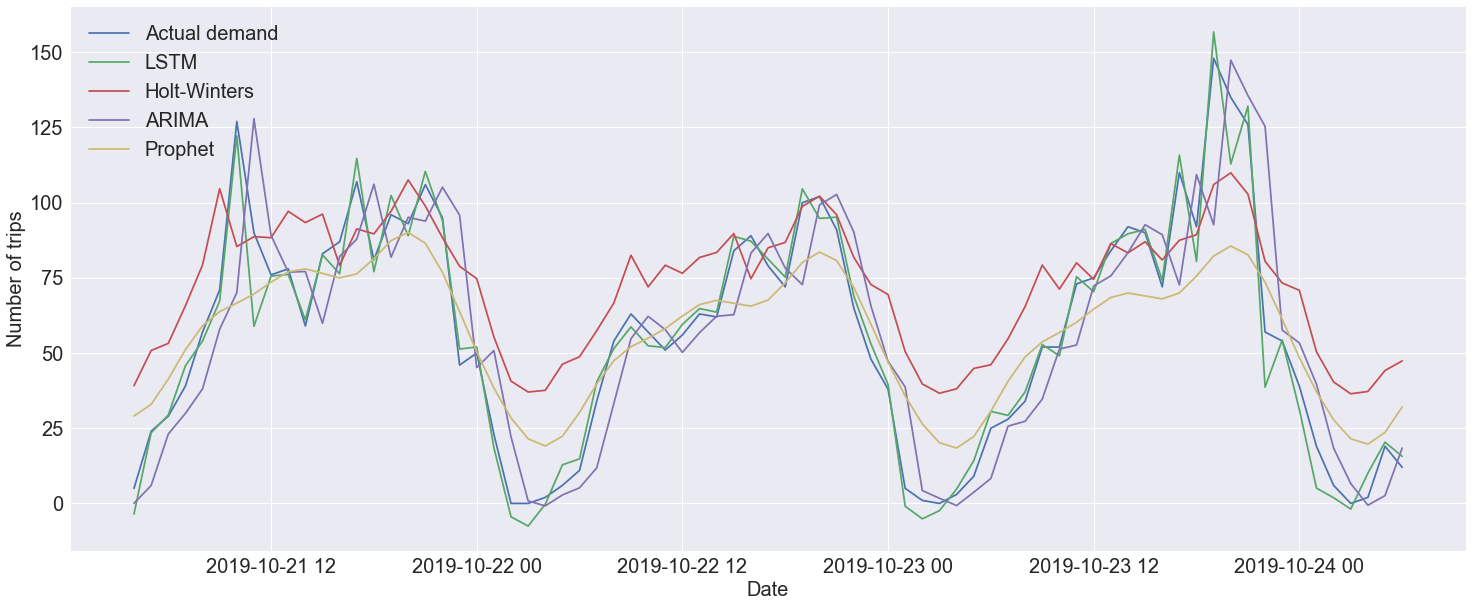

In [43]:
# all models in one plot
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 1], label="Actual demand")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 23], label="LSTM")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 14], label="Holt-Winters")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 17], label="ARIMA")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 20], label="Prophet")

ax.set_ylabel("Number of trips", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc="upper left", fontsize=20)
ax.xaxis.set_major_formatter(myFmt)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.savefig("all models in one plot", dpi=200)

[Text(0, 0, '-25'),
 Text(0, 0, '0'),
 Text(0, 0, '25'),
 Text(0, 0, '50'),
 Text(0, 0, '75'),
 Text(0, 0, '100'),
 Text(0, 0, '125'),
 Text(0, 0, '150'),
 Text(0, 0, '175')]

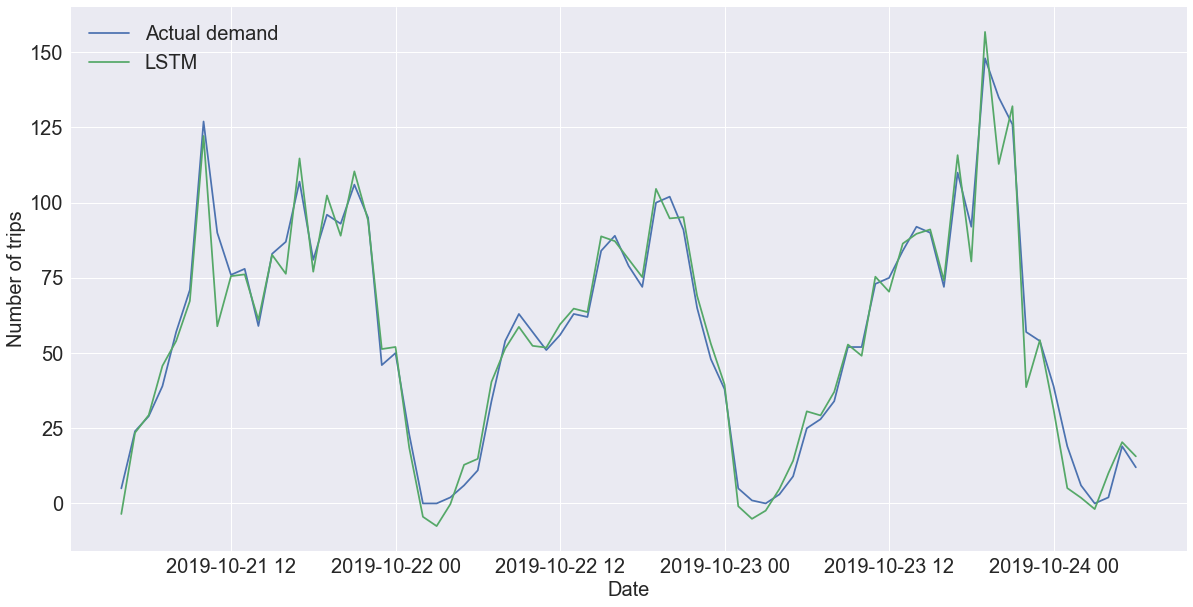

In [40]:
# all actual and LSTM in one plot
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 1], label="Actual demand")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 23], label="LSTM")

ax.set_ylabel("Number of trips", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.legend(loc="best", fontsize=20)
ax.xaxis.set_major_formatter(myFmt)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("all actual and LSTM in one plot", dpi=200)

[Text(0, 0, '-20'),
 Text(0, 0, '0'),
 Text(0, 0, '20'),
 Text(0, 0, '40'),
 Text(0, 0, '60'),
 Text(0, 0, '80'),
 Text(0, 0, '100'),
 Text(0, 0, '120'),
 Text(0, 0, '140'),
 Text(0, 0, '160')]

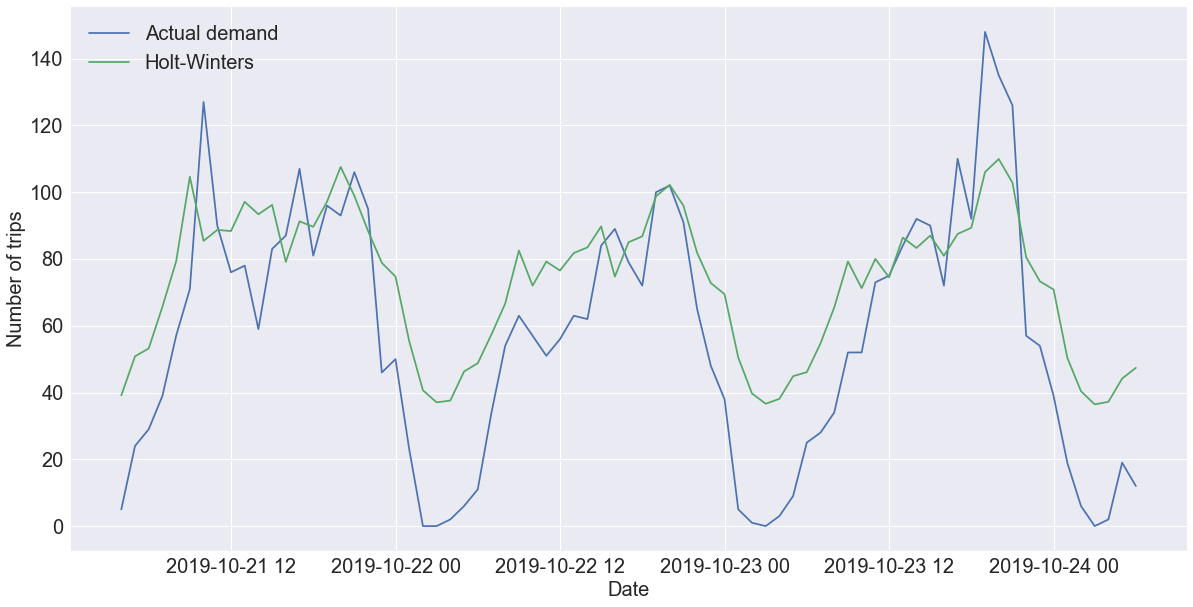

In [38]:
# all actual and HW in one plot
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 1], label="Actual demand")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 14], label="Holt-Winters")

ax.set_ylabel("Number of trips", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.legend(loc="best", fontsize=20)
ax.xaxis.set_major_formatter(myFmt)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("all actual and HW in one plot", dpi=200)

[Text(0, 0, '-20'),
 Text(0, 0, '0'),
 Text(0, 0, '20'),
 Text(0, 0, '40'),
 Text(0, 0, '60'),
 Text(0, 0, '80'),
 Text(0, 0, '100'),
 Text(0, 0, '120'),
 Text(0, 0, '140'),
 Text(0, 0, '160')]

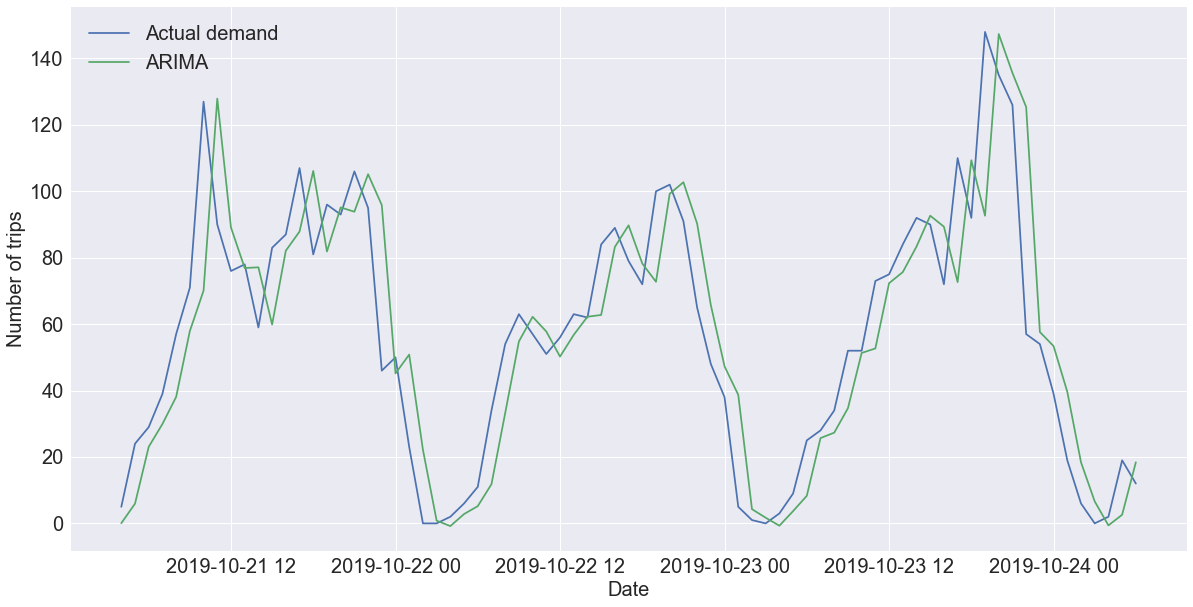

In [36]:
# all actual and ARIMA in one plot
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 1], label="Actual demand")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 17], label="ARIMA")
ax.set_ylabel("Number of trips", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.legend(loc="best", fontsize=20)
ax.xaxis.set_major_formatter(myFmt)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("all actual and ARIMA in one plot", dpi=200)

[Text(0, 0, '-20'),
 Text(0, 0, '0'),
 Text(0, 0, '20'),
 Text(0, 0, '40'),
 Text(0, 0, '60'),
 Text(0, 0, '80'),
 Text(0, 0, '100'),
 Text(0, 0, '120'),
 Text(0, 0, '140'),
 Text(0, 0, '160')]

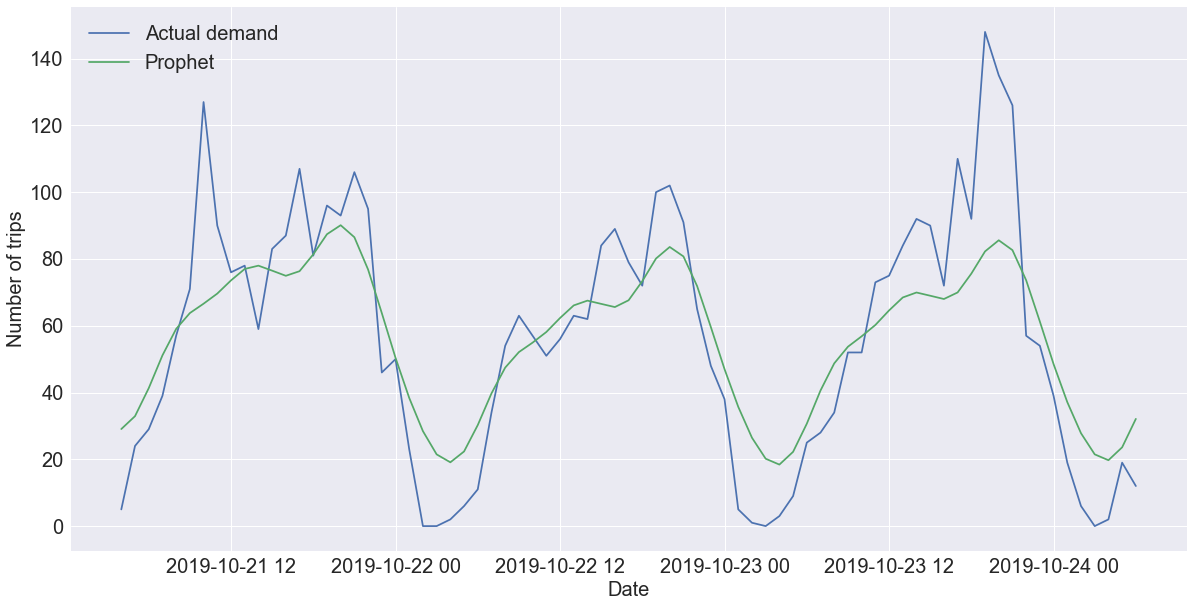

In [34]:
# all actual and Prophet in one plot
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 1], label="Actual demand")
ax.plot(df_plots.iloc[8500:8575].index, df_plots.iloc[8500:8575, 20], label="Prophet")

ax.set_ylabel("Number of trips", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.legend(loc="best", fontsize=20)
ax.xaxis.set_major_formatter(myFmt)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.savefig("all actual and Prophet in one plot", dpi=200)

# Boxplot performance

In [115]:
df_boxplot = pd.read_csv("Boxplots LSTM.csv")

In [116]:
df_boxplot.describe()

,FNS_past,Ohara_past,NWS_past,NS_past,WS_past,CEN_past,SS_past,SWS_past,FSWS_past,FSES_past,...,FNS_past_time_weather,Ohara_past_time_weather,NWS_past_time_weather,NS_past_time_weather,WS_past_time_weather,CEN_past_time_weather,SS_past_time_weather,SWS_past_time_weather,FSWS_past_time_weather,FSES_past_time_weather
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,9.133133,4.204500,2.989967,25.500733,31.204633,43.707300,5.747067,3.696077,2.572533,2.500633,...,7.272496,3.871010,2.800173,24.299076,26.970458,35.350858,4.569701,2.847622,2.234431,2.177756
std,0.355827,0.175452,0.104436,0.595981,1.134518,1.046716,0.403012,0.171181,0.082912,0.098122,...,0.341777,0.394814,0.197637,1.164208,3.439745,3.054427,0.370416,0.406627,0.150834,0.160753
min,8.527000,3.899000,2.680000,24.346000,27.968000,41.423000,5.060000,3.419000,2.461000,2.374000,...,6.663369,3.111637,2.188568,22.005148,21.056427,27.068350,3.899428,1.218477,1.865201,1.787734
25%,8.940000,4.061750,2.932500,25.134250,30.700000,43.247000,5.549000,3.565750,2.525250,2.471000,...,6.969230,3.608116,2.710654,23.609011,24.706806,33.672853,4.346216,2.685336,2.188759,2.108991
50%,9.084000,4.218000,2.984500,25.549000,31.233500,43.856000,5.758000,3.701000,2.559500,2.490000,...,7.350394,3.887359,2.810658,24.460695,26.484828,35.477667,4.586108,2.937765,2.225591,2.178862
75%,9.386500,4.340500,3.052250,25.804250,31.823500,44.252750,5.847750,3.766750,2.590250,2.503750,...,7.531398,4.100422,2.912935,24.980348,29.865015,37.814631,4.865319,3.107399,2.331369,2.284692
max,10.271000,4.471000,3.312000,26.938000,33.713000,45.380000,6.910000,4.177000,2.897000,2.970000,...,7.804234,4.666895,3.202434,26.162077,35.766497,40.082150,5.265240,3.301873,2.493065,2.473842


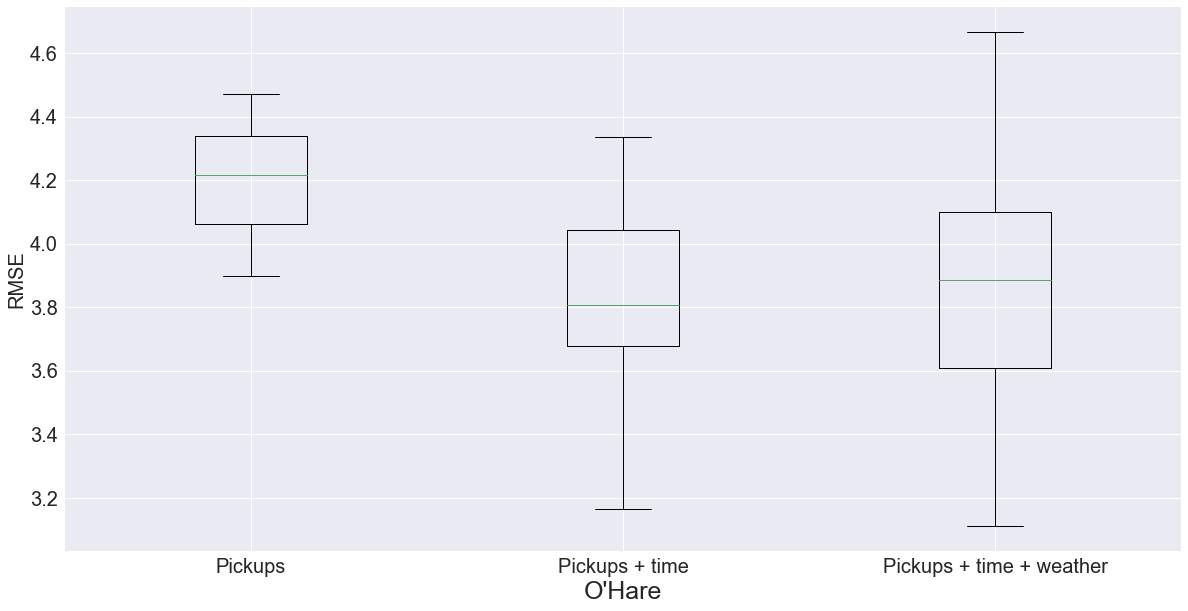

In [131]:
# boxplot North Side and CEN

FNS_past = df_boxplot["FNS_past"]
FNS_past_time = df_boxplot["FNS_past_time"]
FNS_past_time_weather = df_boxplot["FNS_past_time_weather"]

Ohara_past = df_boxplot["Ohara_past"]
Ohara_past_time = df_boxplot["Ohara_past_time"]
Ohara_past_time_weather = df_boxplot["Ohara_past_time_weather"]

NWS_past = df_boxplot["NWS_past"]
NWS_past_time = df_boxplot["NWS_past_time"]
NWS_past_time_weather = df_boxplot["NWS_past_time_weather"]

NS_past = df_boxplot["NS_past"]
NS_past_time = df_boxplot["NS_past_time"]
NS_past_time_weather = df_boxplot["NS_past_time_weather"]

WS_past = df_boxplot["WS_past"]
WS_past_time = df_boxplot["WS_past_time"]
WS_past_time_weather = df_boxplot["WS_past_time_weather"]

CEN_past = df_boxplot["CEN_past"]
CEN_past_time = df_boxplot["CEN_past_time"]
CEN_past_time_weather = df_boxplot["CEN_past_time_weather"]

SS_past = df_boxplot["SS_past"]
SS_past_time = df_boxplot["SS_past_time"]
SS_past_time_weather = df_boxplot["SS_past_time_weather"]

SWS_past = df_boxplot["SWS_past"]
SWS_past_time = df_boxplot["SWS_past_time"]
SWS_past_time_weather = df_boxplot["SWS_past_time_weather"]

FSWS_past = df_boxplot["FSWS_past"]
FSWS_past_time = df_boxplot["FSWS_past_time"]
FSWS_past_time_weather = df_boxplot["FSWS_past_time_weather"]

FSES_past = df_boxplot["FSES_past"]
FSES_past_time = df_boxplot["FSES_past_time"]
FSES_past_time_weather = df_boxplot["FSES_past_time_weather"]

positions = (1,2,3)
labels = ("Pickups", "Pickups + time", "Pickups + time + weather")

fig, ax = plt.subplots(figsize=(20,10))
ax.boxplot([Ohara_past, Ohara_past_time, Ohara_past_time_weather] )

ax.set_ylabel("RMSE", fontsize=20)
ax.set_xlabel("O'Hare", fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_xticklabels(labels)

# ax.set_ylim(18,30) # adjust y axis range for numeric input

plt.savefig("boxplot Ohare", dpi=200)

# Time series decomposition

In [132]:
import statsmodels.api as sm

In [161]:
# Import hourly pickups by Chicago Side
df_sides = pd.read_csv("hour_pickups_sides_final.csv")
df_sides["StartTime"] = pd.to_datetime(df_sides["StartTime"], 
                                       format="%d/%m/%Y %H:%M")
# set index
df_sides.set_index("StartTime", inplace=True)

In [162]:
df_sides.head(2)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season,Total
StartTime,,,,,,,,,,,,,,
2018-11-01 00:00:00,70,15,20,174,134,141,48,25,17,12,0,0,2,656
2018-11-01 01:00:00,46,5,9,200,94,103,22,16,17,7,0,0,2,519


In [163]:
df_sides.iloc[:,-1].value_counts()

1376    19
1099    15
1122    14
717     14
149     14
        ..
1643     1
1523     1
3170     1
915      1
2093     1
Name: Total, Length: 2270, dtype: int64

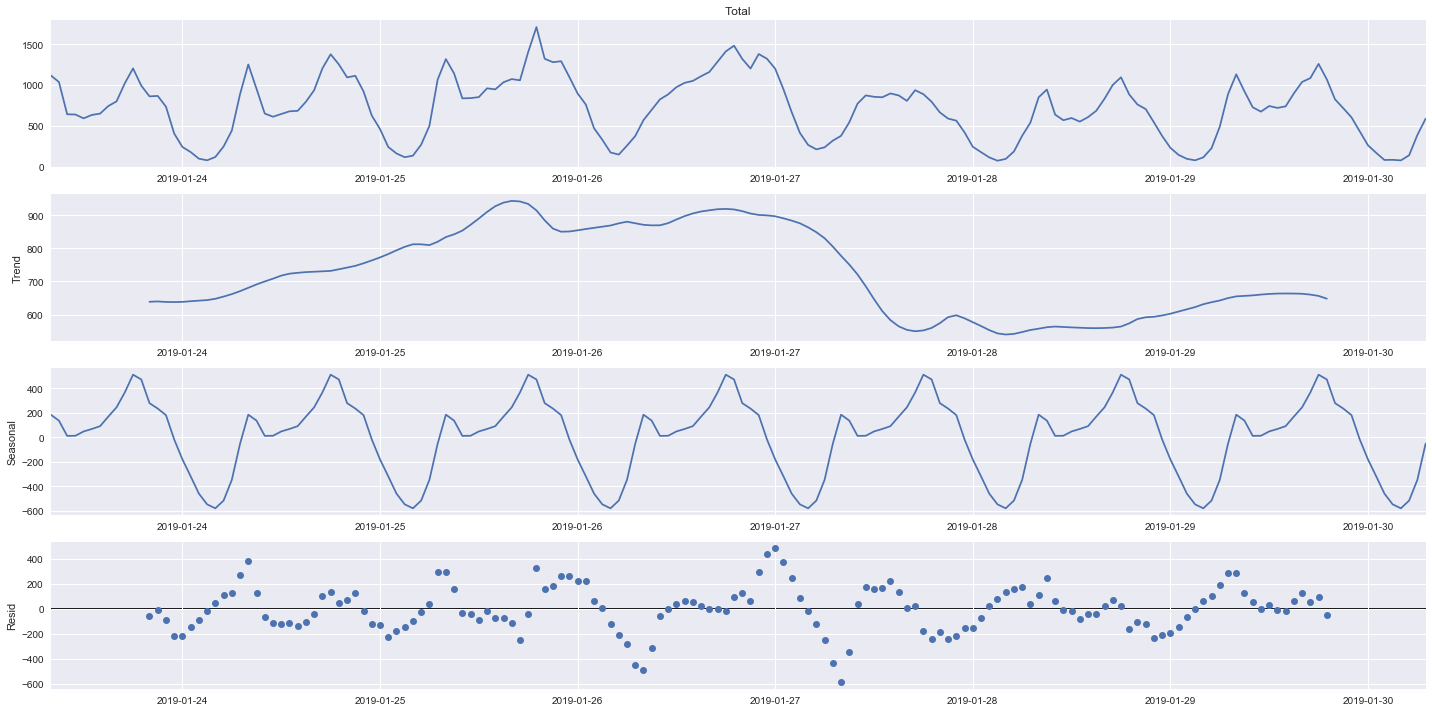

In [176]:
decomposition = sm.tsa.seasonal_decompose(df_sides.iloc[2000:2168,-1], model="additive")
decomposition.plot()
plt.rcParams["figure.figsize"] = [20, 10]
# plt.savefig("Hourly pickups time series decomposed 2019-01-23 08 2019-01-30 07 ", dpi=100)

In [175]:
df_sides.iloc[2000:2168,-1].index

DatetimeIndex(['2019-01-23 08:00:00', '2019-01-23 09:00:00',
               '2019-01-23 10:00:00', '2019-01-23 11:00:00',
               '2019-01-23 12:00:00', '2019-01-23 13:00:00',
               '2019-01-23 14:00:00', '2019-01-23 15:00:00',
               '2019-01-23 16:00:00', '2019-01-23 17:00:00',
               ...
               '2019-01-29 22:00:00', '2019-01-29 23:00:00',
               '2019-01-30 00:00:00', '2019-01-30 01:00:00',
               '2019-01-30 02:00:00', '2019-01-30 03:00:00',
               '2019-01-30 04:00:00', '2019-01-30 05:00:00',
               '2019-01-30 06:00:00', '2019-01-30 07:00:00'],
              dtype='datetime64[ns]', name='StartTime', length=168, freq=None)